In [1]:
import pandas as pd
import numpy as np

In [2]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round3'

In [3]:
%cd ../../../

/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow


In [4]:
df = pd.read_csv('data/round3/raw/ink_all.csv')
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)


In [5]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df

In [6]:
#计算趋势线
def calculate_ma(df):
    df = df.copy()
    df['MA20'] = df['mid_price'].rolling(window=20).mean()
    df['MA60'] = df['mid_price'].rolling(window=60).mean()
    df['MA120'] = df['mid_price'].rolling(window=120).mean()
    df['MA200'] = df['mid_price'].rolling(window=200).mean()

    df['delta20'] = df['mid_price'] - df['MA20']
    df['delta60'] = df['mid_price'] - df['MA60']
    df['delta120'] = df['mid_price'] - df['MA120']
    df['delta200'] = df['mid_price'] - df['MA200']
    df.dropna(inplace = True)
    return df


In [7]:
df = orderbook_preprocess(df)
df = calculate_ma(df)

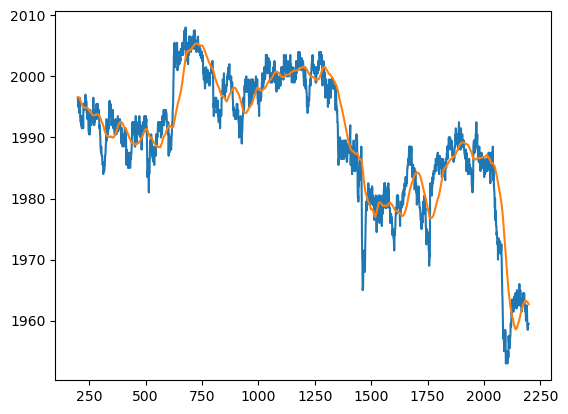

In [8]:
import matplotlib.pyplot as plt
plt.plot(df['mid_price'][:2000])
plt.plot(df['MA60'][:2000])

<Axes: xlabel='delta20', ylabel='Count'>

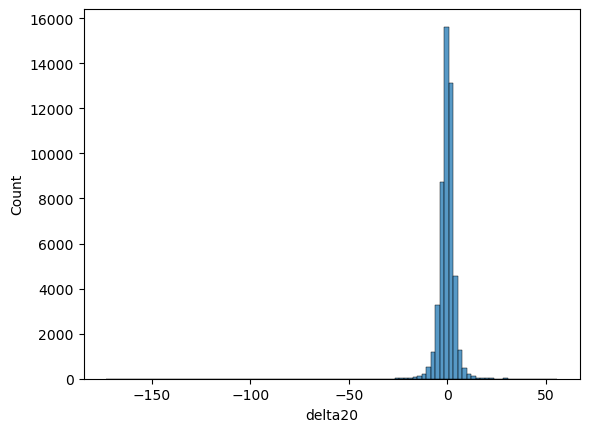

In [9]:
import seaborn as sns
#画出df['delta']列的hist
sns.histplot(df['delta20'], bins=100, kde=False)

Text(0.5, 1.0, 'Fit results: mu = -0.03,  std = 4.26')

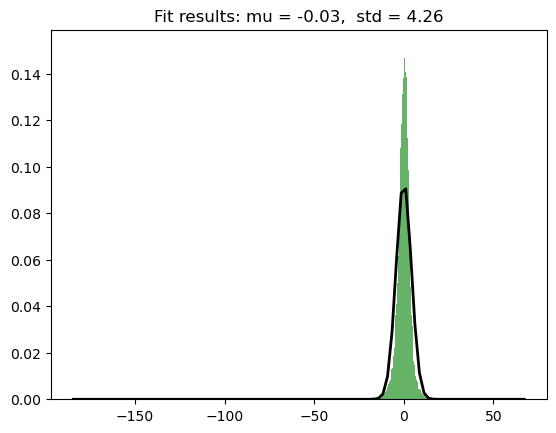

In [10]:
#正态分布拟合
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = df['delta20']
# Fit a normal distribution to the data
mu, std = norm.fit(data)
# Plot the histogram of the data
plt.hist(data, bins=500, density=True, alpha=0.6, color='g')
# Plot the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)


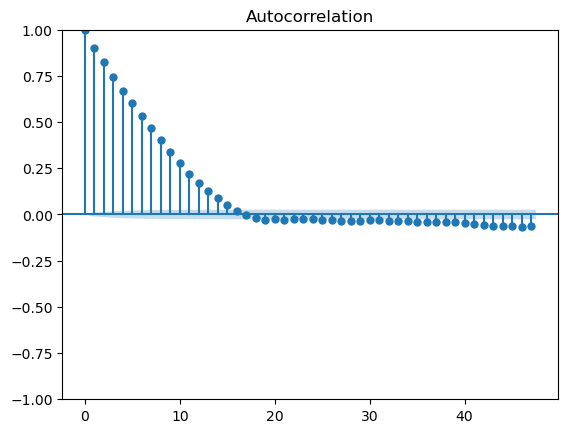

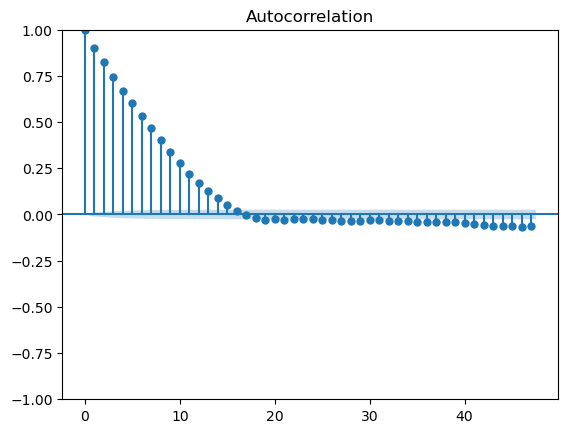

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['delta20']) 

In [12]:
import numpy as np
import statsmodels.api as sm

def half_life(residuals):
    lagged = residuals.shift(1)
    delta = residuals - lagged
    beta = sm.OLS(delta[1:], sm.add_constant(lagged[1:])).fit().params[1]
    return -np.log(2) / beta if beta < 0 else np.inf

In [13]:
half_life20 = half_life(df['delta20'])
half_life60 = half_life(df['delta60'])
half_life120 = half_life(df['delta120'])
half_life200 = half_life(df['delta200'])

/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_24838/1056656099.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(delta[1:], sm.add_constant(lagged[1:])).fit().params[1]
/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_24838/1056656099.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(delta[1:], sm.add_constant(lagged[1:])).fit().params[1]
/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_24838/1056656099.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

In [14]:
print(f"half_life20: {half_life20}, half_life60: {half_life60}, half_life120: {half_life120}, half_life200: {half_life200}")

half_life20: 7.12304277221937, half_life60: 20.190627196236047, half_life120: 35.435446930579424, half_life200: 53.69047194963603


In [15]:
print(df.columns)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'best_bid', 'best_ask', 'spread', 'vwap', 'orderbook_imbalance',
       'ask_volume', 'bid_volume', 'ask_bid_ratio', 'MA20', 'MA60', 'MA120',
       'MA200', 'delta20', 'delta60', 'delta120', 'delta200'],
      dtype='object')


In [16]:
#计算mad
df['MAD200'] = df['mid_price'].rolling(window=200).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)

break
False    49366
True       435
Name: count, dtype: int64


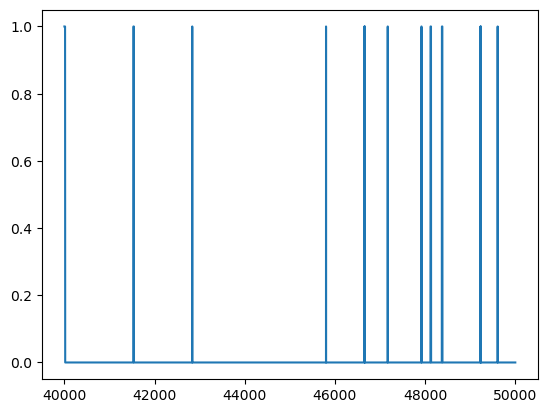

In [17]:
band_width = 5 * df['MAD200']
df['break'] = (df['mid_price'] > df['MA200'] + band_width) | (df['mid_price'] < df['MA200'] - band_width)

print(df['break'].value_counts())
#如果break = True就赋值为1
df['break'] = df['break'].apply(lambda x: 1 if x == True else 0)
plt.plot(df['break'][-10000:])

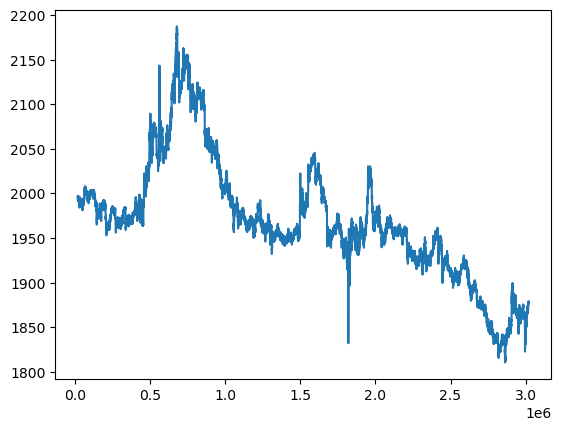

In [68]:
plt.plot(df['mid_price'][:30000])

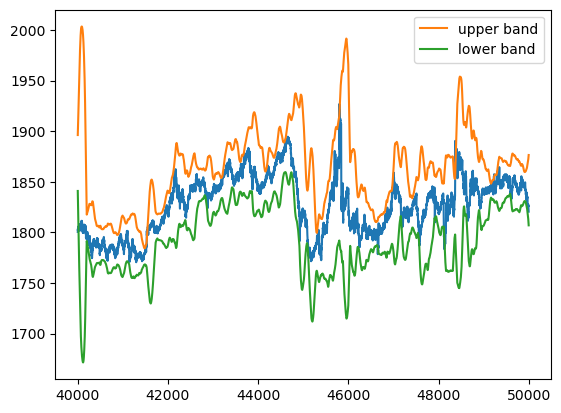

In [20]:
plt.plot(df['mid_price'][-10000:])
#画出band
plt.plot(df['MA200'][-10000:] + band_width, label='upper band')
plt.plot(df['MA200'][-10000:] - band_width, label='lower band')
plt.legend()

In [52]:
import pandas as pd
df1 = pd.read_csv('data/round-1-island-data-bottle/trades_round_1_day_-2.csv', delimiter=';')
df2 = pd.read_csv('data/round-1-island-data-bottle/trades_round_1_day_-1.csv', delimiter = ';')
df3 = pd.read_csv('data/round-1-island-data-bottle/trades_round_1_day_0.csv', delimiter = ';')
df4 = pd.read_csv('data/round-3-island-data-bottle/trades_round_3_day_1.csv', delimiter = ';')
df5 = pd.read_csv('data/round-3-island-data-bottle/trades_round_3_day_2.csv', delimiter = ';')
df1['day'] = -2
df2['day'] = -1
df3['day'] = 0
df4['day'] = 1
df5['day'] = 2
df_list = [df1, df2, df3, df4, df5]
#合并相同timestamp的数据，累加
for df_trade in df_list:
    df_trade = df_trade.groupby(['timestamp', 'day']).agg({
        'price': 'mean',
        'quantity': 'sum',
        'buyer': 'first', 
        'seller': 'first', 
        'symbol': 'first', 
        'currency': 'first'
    })

df_trade = pd.concat([df1, df2, df3, df4, df5])
df_trade = df_trade[df_trade['symbol'] == 'SQUID_INK']

In [53]:
df_trade['timestamp'] = df_trade['timestamp'] + (df_trade['day'] + 2) * 1000000
df_trade.set_index('timestamp', inplace=True)

In [55]:
df_trade['quantity'].describe()

count    14758.000000
mean         2.849641
std          3.324913
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         15.000000
Name: quantity, dtype: float64

In [62]:
#过滤成交量
quantity_threshold = 15
df_trade['quantity'] = df_trade['quantity'].apply(lambda x: 1 if abs(x) >= quantity_threshold else 0)

In [63]:
df_trade['timestamp'] = df_trade.index

In [65]:
df.set_index('timestamp', inplace=True)

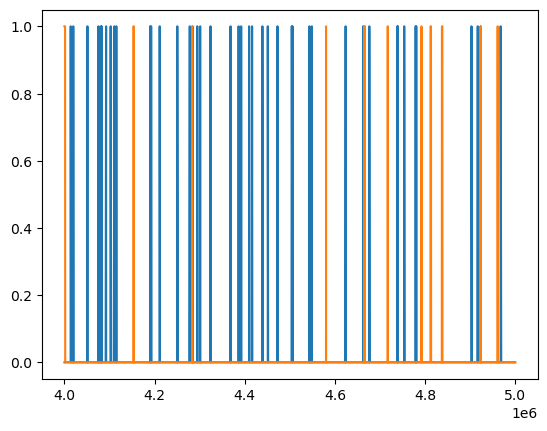

In [66]:
plt.plot(df_trade[df_trade['timestamp'] >= 4000000]['quantity'])
plt.plot(df['break'][-10000:])